## Training and validation of goggle quick-draw drawings

We train using compressed simplified drawings that are converte to images during training


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from code import *
from graphics import *

import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import gc

In [9]:
input_data       = Path("/Users/kasparlund/DropBox")
data             = Path("../data/google_quick_draw")

stroke_dir       = input_data/"train_simplified"
one_stroke_file  = stroke_dir/"ambulance.csv"

data_prepared    = data/"prepared"

attribute_file  = data_prepared/"train_simplified_attributes.csv"
vocab_file       = data_prepared/"vocab.json"


size, line_width  = 28, 1
valid_ratio = 0.1
linetype    = cv2.LINE_8 #cv2.LINE_AA
compressed_drawings = True

images_file      = data_prepared/f"imgs_webp_{size}x{size}_lw{line_width}.pkl"
drawings_file    = data_prepared/f"c_drawings.pkl"
train_valid_name = "c_drawing_train_valid" if compressed_drawings else \
                    f"c_image_train_valid_{size}x{size}_lw{line_width}.gzip"
train_valid_file = data_prepared/f"{train_valid_name}.gzip"

print(data.exists()), print(one_stroke_file.exists())
attribute_file, train_valid_file

True
True


(PosixPath('../data/google_quick_draw/prepared/train_simplified_attributes.csv'),
 PosixPath('../data/google_quick_draw/prepared/c_drawing_train_valid.gzip'))

In [6]:
#load the data
%time df_train = pd.read_pickle(train_valid_file)
gc.collect()

CPU times: user 13.3 s, sys: 21.7 s, total: 35 s
Wall time: 43.8 s


0

reading and converting compressed drawings to images
CPU times: user 81.1 ms, sys: 4.09 ms, total: 85.2 ms
Wall time: 85.1 ms
plot images : 1000


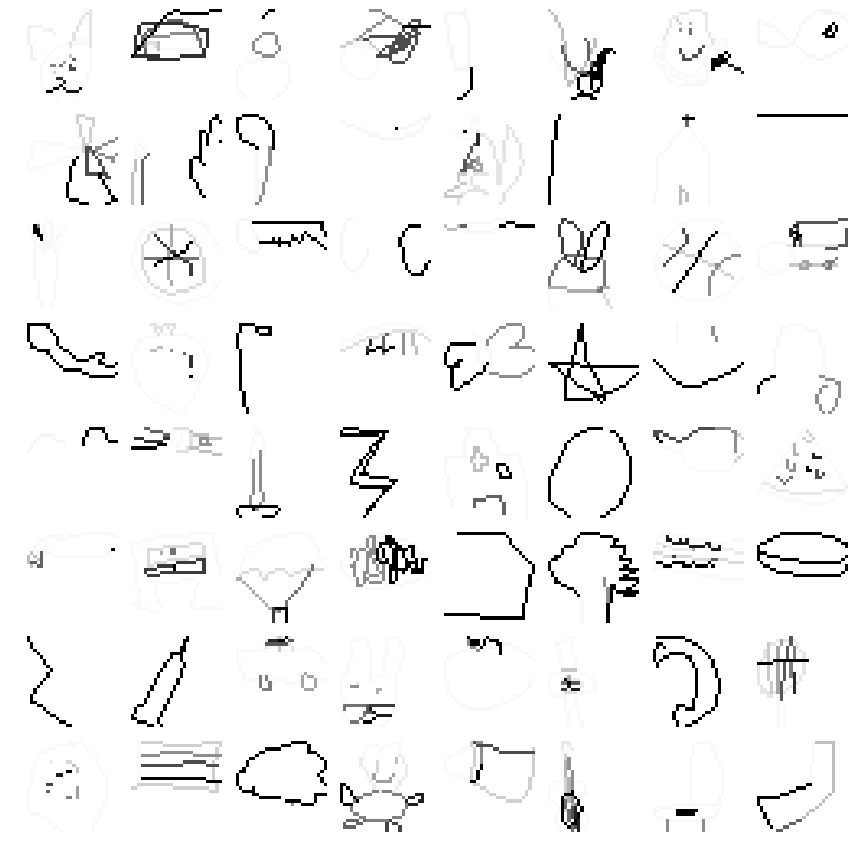

In [7]:
#verify the data by drawing some images 
print("reading and converting compressed drawings to images")
compressed = [df_train.c_drawings.iloc[i] for i in np.random.randint(0,len(df_train),100) ]
%time ims = convert_strokes2image(compressed, size, line_width, linetype, compressed_drawings) 
    
print(f"plot images : {len(ims)}")
plot_images( ims, cm.Greys, max_rows_cols=8 )